In [1]:
using LinearAlgebra
include("plotting.jl")
include("meshing.jl")
nothing

In [2]:
stiffness_element(lx, ly) =
[lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx
 lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx]

mass_element(lx, ly) = (lx * ly) / 6.0 *
[ 2. 0 -1  0
  0  2  0 -1
 -1  0  2  0
  0 -1  0  2]

# WARNING: works ONLY for x̂ normal direction!
abc(x̂) = (ly) *
[ 0. 0  0  0
  0  1  0  0
  0  0  0  0
  0  0  0  1]

abc (generic function with 1 method)

In [3]:
# Circuit
Z0 = 13.2
Rs = 3000 # Ω
RL = 2Z0  # Ω
V0 = 5000 # V

# Parameters
Δt = 0.05e-9
ε0 = 8.854e-12
μ0 = 4e-7π
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr
η  = sqrt(μ / ε)

n̂  = x̂ = [1.0, 0.0]
nothing

In [4]:
a, b = 2.00, 0.08
n, m = 100, 4
lx = a / n
ly = b / m
el2ed, el2edd = quadmesh(a, b, n, m);

In [5]:
DOF_NONE = 0
DOF_PEC  = 1
DOF_SRC  = 2
DOF_ABC  = 3
DOF_LOAD = 4
DOF_SG   = 5

function dof_type(n, m)
    global NUM_EDGES
    N = NUM_EDGES
    h = [  1+(2n+1)i: n+0+(2n+1)i for i=0:m]
    v = [n+1+(2n+1)i:2n+1+(2n+1)i for i=0:m-1]
    start, stop = extrema(h[3])
    h[3] = start:stop - 5
    
    dof_flag = zeros(Int64, N)
    
    dof_flag[(h[1])] .= DOF_PEC # BOTTOM
    dof_flag[(h[3])] .= DOF_PEC # MIDDLE
    dof_flag[(h[5])] .= DOF_PEC # TOP
    
    dof_flag[first(v[1])] = DOF_SRC
    dof_flag[first(v[2])] = DOF_SRC
    
    dof_flag[first(v[3])] = DOF_SG
    dof_flag[first(v[4])] = DOF_SG
    
    dof_flag[ last(v[1])] = DOF_LOAD
    dof_flag[ last(v[2])] = DOF_LOAD
    dof_flag[ last(v[3])] = DOF_LOAD
    dof_flag[ last(v[4])] = DOF_LOAD
    
    return dof_flag
end

dof_type (generic function with 1 method)

In [6]:
dof = collect(1:NUM_EDGES)

Γ = dof_type(n, m)
f = Γ .!= DOF_PEC
NUM_DOFS = NUM_EDGES;

In [7]:
using SparseArrays
# ASSUMPTION: Waveguide is homogenous
# Assemble stiffness and mass matrices
S = spzeros(NUM_DOFS, NUM_DOFS) # 1/μr ∫( ∇Ni × ∇Nj )dΩ
R = spzeros(NUM_DOFS, NUM_DOFS) # μ0 σ ∫( ∇Ni ⋅ ∇Nj )dΩ
T = spzeros(NUM_DOFS, NUM_DOFS) # μ0 ε ∫( ∇Ni ⋅ ∇Nj )dΩ
B = spzeros(NUM_DOFS, NUM_DOFS) # μ0/η ∫(( n̂ × ∇Ni ) ⋅ ( n̂ × ∇Nj ))dΓ

# ASSUMPTION: Waveguide is homogenous
for ielem = 1:NUM_ELEMS # Assemble by elements
  Se = stiffness_element(lx, ly)
  Te = mass_element(lx, ly)
  Be = abc(n̂) # works only for x̂ normal direction
  
  for jedge = 1:4
    dj = el2edd[ielem, jedge]
    jj = dof[el2ed[ielem, jedge]]
    if jj == 0
      continue
    end
    
    for kedge = 1:4
      dk = el2edd[ielem, kedge]
      kk = dof[el2ed[ielem, kedge]]
      if kk == 0
        continue
      end

      S[jj, kk] = S[jj, kk] + dj * dk * (1/μr) * Se[jedge, kedge]
      T[jj, kk] = T[jj, kk] + dj * dk * (μ0*ε) * Te[jedge, kedge]
            
    
      if Γ[jj] == DOF_ABC
        B[jj, kk] = B[jj, kk] + (μ0/η) * dj * dk * Be[jedge, kedge]
      end
    end
  end
end

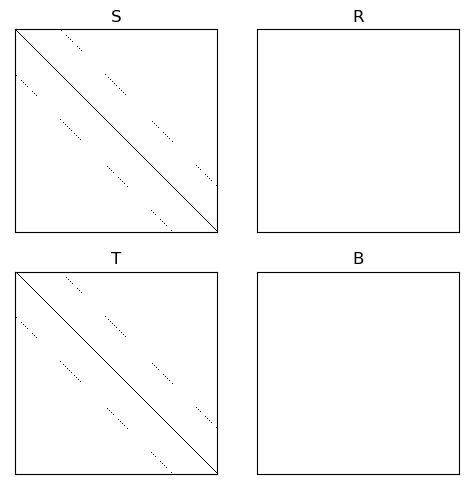

In [8]:
using PyPlot
figure(figsize=(5, 5))
subplot(2, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
subplot(2, 2, 2); spy(R); title("R"); xticks([]); yticks([]);
subplot(2, 2, 3); spy(T); title("T"); xticks([]); yticks([]);
subplot(2, 2, 4); spy(B); title("B"); xticks([]); yticks([]);
tight_layout()

In [9]:
A  = (+0.25Δt^2 * S +  T + 0.5Δt * B + 0.5Δt * R)
for ii = 1:NUM_EDGES
  if Γ[ii] == DOF_PEC
        A[:,dof[ii]].= 0.0
        A[dof[ii],:].= 0.0
        A[dof[ii], dof[ii]] = 1.0
  end
end

In [10]:
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end

import Base: +, -, *, /, ^
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)
^(x::Dual, y::Float64) = Dual(x.v^y, !iszero(y)* x.dv * y * x.v^(y-1))

import Base: abs, sin, cos, tan, exp, log, sqrt, conj, abs2, isless, isapprox
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
log(x::Dual)  = Dual(log(x.v), x.dv/x.v)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
conj(x::Dual) = x
abs2(x::Dual) = abs(x) * abs(x)
isless(x::Dual, y::Dual) = x.v < y.v
isless(x::Float64, y::Dual) = x < y.v
isless(x::Dual, y::Float64) = x.v < y
isapprox(x::Dual{Float64}, y::Float64) = x.v ≈ y


import Base: convert, promote_rule
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}

import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ε]");
value(x::Dual) = x.v;
value(x::Float64) = x;
partials(x::Dual) = x.dv;

ε = Dual(0., 1.)

(0.0) + [1.0ε]

In [11]:
mm = 1e-3 # m
atm = 101_325.0 # Pa
gasdensity(p) = 1.2p/1atm # at 25 degrees C.
electricfield(V, d) = V/d

# channel radius
# ρ in [kg/m3], i in [A], t in [s], result in [m]
braginskii(ρ, i, t) = 9.3e-4 * (1e-3*i)^(1/3) *
                               (1e+6*t)^(1/2) *
                               (1e-3*ρ)^(1/6)
# breakdown delay
# E in [V/m], ρ in [kg/m3], result in [s]
thmartin(E, ρ) = (987e2/1e-3ρ) * (1e-5E/1e-3ρ)^(-3.44)

# breakdown voltage
# p in [Pa], d in [m], result in [V]
bruce(p, d) = 24550 *     (1e2d * p / 1atm) + 
               6660 * sqrt(1e2d * p / 1atm)

# wire inductance
# r in [m], d in [m], result in [H] 
grover(r, d) = 200e-9d * (log(200d / r) - .75)

# arc resistance
# r in [m], d in [m], i in [A], result in [Ω]
vlastos(r, d, ∫i²) = 876d * r^(2/5) / ∫i²^(3/5)
nothing

In [12]:
using StaticArrays
using ACME

params = Dict{String, Any}(
    "pressure" => 1atm,
    "distance" => 1mm,
    "t_arc" => 0.0,
    "t_over" => 0.0,
    "∫i²" => 0.0,
    "Δt" => Δt,
    "v_break" => bruce(1atm, 1mm),
    "i_min" => 5e-5,
    "channel_on" => false,
    "Rch" => NaN,
    "Lch" => NaN,
    "nonlinear" => 0.0
    )


nonlinear_eq = @inline function(q, params)
    v, i, Φ, u = q
    if params["channel_on"] == false
        j = @SVector [(v - u), (i)]
        J = @SMatrix [(1) (0.) (.0) (-1);
                      (0) (1.) (.0) (.0)] 
    else
        if i ≈ 0.0 i = 1e-12 end
        ch_rad = braginskii(gasdensity(params["pressure"]), abs(i), params["t_arc"])
        Ri  = vlastos(ch_rad, params["distance"], params["∫i²"] + (i^2) * params["Δt"]) * i
        dRi = -14.2497 * params["distance"] *
            (abs(i)^(1/3)* gasdensity(params["pressure"])^(1/6) * params["t_arc"]^(1/2)) /
                (i^2 * params["t_arc"])^(3/5)
        Li  = grover(ch_rad, params["distance"])*i
        dLi = 2.0e-7 * params["distance"] *
            (log((215054. * params["distance"]) / 
                (abs(i)^(1/3)* gasdensity(params["pressure"])^(1/6) * params["t_arc"]^(1/2))) -
            1.08333) 

        params["Lch"] = Li / i
        params["Rch"] = Ri / i
        j = @SVector [(Ri - u), (Li - Φ)]
        J = @SMatrix [(0) (dRi) (.0) (-1);
                      (0) (dLi) (-1) (.0)] 
    end
    return (j, J)
    end

afternewton = @inline function(q, params)
    v, i, Φ, u = q
    i = value(i)
    if params["channel_on"]
        if i > params["i_min"]
            params["t_arc"] += params["Δt"]
            params["∫i²"] += i^2 * params["Δt"]
        else
            params["channel_on"] = false
            params["∫i²"] = 0.0
            params["t_arc"] = 0.0
        end
    elseif v > params["v_break"]
        t_delay = thmartin(electricfield(v,params["distance"]), gasdensity(params["pressure"]))
        params["t_over"] += params["Δt"]
        if params["t_over"] > t_delay
            params["channel_on"] = true
            params["∫i²"] = i^2 * params["Δt"]
            params["t_arc"] = params["Δt"]
            params["t_over"] = 0.0
        end
    end
end

arcchannel() =
  ACME.Element(mv=[1;1;0;0;0], mi=[0;0;1;0;0], mx=[0 -1;0 0;0 0;1 0;0 1], mxd=[-1 0;0 0;0 0;0 0;0 0],
        mq=[0 0 0 0;-1 0 0 0;0 -1 0 0; 0 0 -1 0; 0 0 0 -1], ports=[:1 => :2],
        nonlinear_eq = nonlinear_eq)

include("automatic-differentiation.jl")
include("circuit-model.jl")
ϵ # AD seed

(0.0) + [1.0ε]

In [13]:
sparkgap = let
    cir = @circuit begin
        i = currentprobe()
        v = voltagesource()
        ⚡ = arcchannel()
    end

    connect!(cir, (:v, +), (:i, +))
    connect!(cir, (:i, -), (:⚡, 1))
    connect!(cir, (:v, -), (:⚡, 2), :gnd)

    A, B, C, Di, Ei, Fi, Dv, Ev, Fv, Dq, Eq, Fq = matrices(cir, Δt, 1)
    x̄, y, ū, q̄, z = states(B, C, Di, Dq, T=Dual{Float64})
    DifferentiableModel(A, B, C, Di, Ei, Fi, Dq, Eq, Fq,
        x̄, y, ū, q̄, z, params)
end
nothing

In [14]:
voltage = let
    cir = @circuit begin
        i = currentprobe()
        u = voltagesource()
        v = voltagesource()
        l = inductor(1e-12)
        r = resistor(Rs)
    end

    connect!(cir, (:u, +), (:v, -))
    connect!(cir, (:v, +), (:l, 1))
    connect!(cir, (:l, 2), (:r, 1))
    connect!(cir, (:r, 2), (:i, +))
    connect!(cir, (:i, -), :gnd)
    connect!(cir, (:u, -), :gnd)


    A, B, C, Di, Ei, Fi, Dv, Ev, Fv, Dq, Eq, Fq = matrices(cir, Δt, 1)
    x̄, y, ū, q̄, z = states(B, C, Di, Dq, T=Dual{Float64})
    DifferentiableModel(A, B, C, Di, Ei, Fi, Dq, Eq, Fq,
        x̄, y, ū, q̄, z, params)
end
nothing

In [15]:
function pass(q, p) end
function assemble_circuit!(i, didv, v, t)
    vL = sum(v[dof[Γ .== DOF_LOAD]])
    vSG = sum(v[dof[Γ .== DOF_SG]])
    vSRC = sum(v[dof[Γ .== DOF_SRC]])
    
    fix!(sparkgap)
    fix!(voltage)
    y = step!(copy(sparkgap), vSG + ϵ, nonlinear_eq, pass)
    z = step!(copy(voltage),[vSRC + ϵ; V0])
    for ii = 1:NUM_EDGES
        jj = dof[ii]
        if Γ[ii] == DOF_SG
            i[jj] = value(first(y)) * (b / ly)
            didv[jj, jj] =  partials(first(y)) * (b / ly)
        end

        if Γ[ii] == DOF_SRC
            i[jj] = value(first(z)) * (b / ly)
            didv[jj, jj] = partials(first(z)) * (b / ly)
        end

        if Γ[ii] == DOF_LOAD
            i[jj] = v[jj] * 1.0 / RL * (b / ly)
            didv[jj, jj] =  1.0 / RL * (b / ly)
        end
    end
end

assemble_circuit! (generic function with 1 method)

In [16]:
using JLD2

x = 0.010:0.050:0.51
y = 0.005:0.012:0.07
xx, yy = meshgrid(x, y);

it  = 1
nt  = 40_000
t   = 0.00
e   = zeros(NUM_EDGES)
i   = zeros(NUM_EDGES)

e0  = zeros(NUM_EDGES)
ep  = zeros(NUM_EDGES)
epp = zeros(NUM_EDGES)
ip  = zeros(NUM_EDGES)
ipp = zeros(NUM_EDGES)
isrc = zeros(NUM_EDGES)

#t  += 10Δt
#e0 .= -2.5e3load("blumlein-e0-$n-$m-$a-$b.jld2", "e0")
#ep .= e0
#epp.= e0

didv = spzeros(NUM_EDGES, NUM_EDGES)
res = zeros(nt, 11, 6, 2)
vRsg = zeros(nt)
vRL  = zeros(nt)
vRs  = zeros(nt)
iRsg = zeros(nt)
iRL  = zeros(nt)
iRs  = zeros(nt)
resistance = zeros(nt)
inductance = zeros(nt)
nothing

In [17]:
using ProgressMeter; 
ProgressMeter.ijulia_behavior(:clear)
progress = Progress(nt - it + 1)

N = 0
Δe = similar(e)
Fi = zeros(NUM_EDGES)
Ji = spzeros(NUM_EDGES, NUM_EDGES)
for _ = it:nt
    bi = (0.50Δt^2 * S - 2T) * ep + (0.25Δt^2 * S +  T - 0.5Δt * B - 0.5Δt * R) * epp
    
    fill!(Δe, Inf)
    while norm(Δe) > 1e-12 && N < 10
        assemble_circuit!(i, didv, e, t)
        Fi .= A*e + 0.5Δt * ly^2 * μ0 * i - 0.5Δt * ly^2 * μ0 * ipp + bi
        Ji .= A   + 0.5Δt * ly^2 * μ0 * didv
        Δe .= Ji\Fi
        e .-= Δe
        N += 1
    end
    
    assemble_circuit!(i, didv, e, t)
    fix!(sparkgap)
    fix!(voltage)
    step!(sparkgap, sum(e[dof[Γ .== DOF_SG]]), nonlinear_eq, afternewton)
    step!(voltage, [sum(e[dof[Γ .== DOF_SRC]]); V0])
    N = 0
    
    epp .= ep
    ep  .= e

    ipp .= ip
    ip  .= i
    
    res[it, :, :, :] .= evaluate(WhitneyRectangleElement(), e, dof, x, y, n, m, lx, ly, el2ed, el2edd)
    vRsg[it] = sum(e[dof[Γ .== DOF_SG]])
    vRL[it]  = sum(e[dof[Γ .== DOF_LOAD]])
    vRs[it]  = sum(e[dof[Γ .== DOF_SRC]])
    iRsg[it] = sum(i[dof[Γ .== DOF_SG]])
    iRL[it]  = sum(i[dof[Γ .== DOF_LOAD]])
    iRs[it]  = sum(i[dof[Γ .== DOF_SRC]])

    resistance[it] = value(params["Rch"])
    inductance[it] = value(params["Lch"])
    
    it += 1
    t  += Δt
    
    update!(progress, it; showvalues=[
            (:t, 1e9t),
            (:channel, params["channel_on"]),
            (:nonlinear, norm(Δe)),
            (:nonlinear, value(params["nonlinear"])),
            (:Vsg, vRsg[it-1]),
            (:VL, vRL[it-1])
            ])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:30
  t:          1999.949999998321
  channel:    false
  nonlinear:  1.9455522841577727e-12
  nonlinear:  0.0
  Vsg:        2135.2662513884834
  VL:         -50.038369379899464


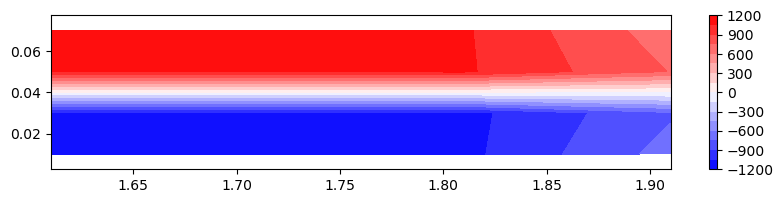

(-1095.6819174923558, 1070.703427249127)

In [18]:
x = 1.61:0.10:2.00
y = 0.01:0.02:0.08
E = evaluate(WhitneyRectangleElement(), e, dof, x, y, n, m, lx, ly, el2ed, el2edd)
normE  = @. sqrt(E[:, :, 1]^2 + E[:, :, 2]^2)
xx, yy = meshgrid(x, y);

figure(figsize=(10, 2))
contourf(xx', yy', E[:, :, 2], cmap=PyPlot.get_cmap("bwr"), levels=20)
axis("equal"); colorbar();
extrema(E[:,:,2])

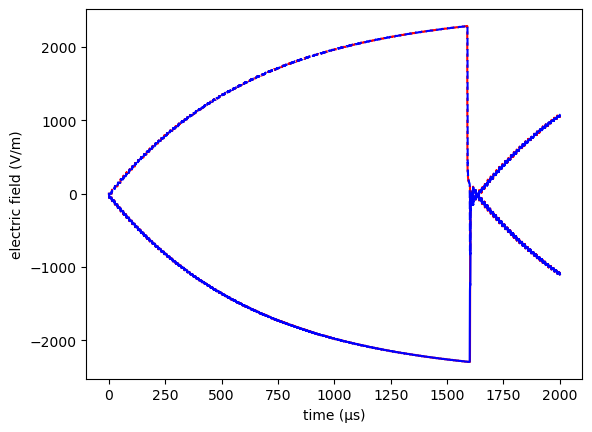

PyObject Text(24.0, 0.5, 'electric field (V/m)')

In [19]:
using PyPlot

ts = 1e9Δt * collect(1:nt)
plot(ts, res[:, 3, 1, 2], "r-")
plot(ts, res[:, 3, 6, 2], "r--")
plot(ts, res[:, 9, 1, 2], "b-")
plot(ts, res[:, 9, 6, 2], "b--")
xlabel("time (μs)")
ylabel("electric field (V/m)")

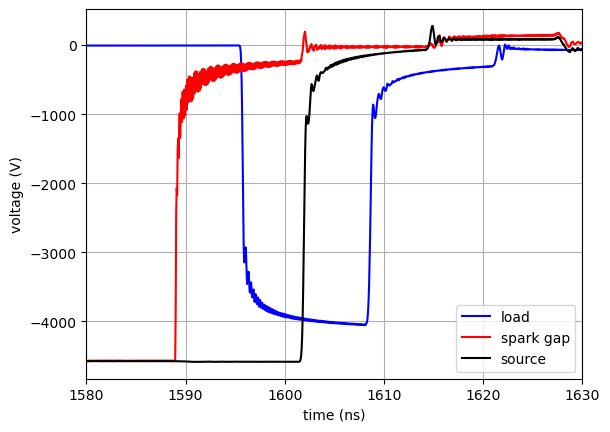

PyObject <matplotlib.legend.Legend object at 0x7fd78a2e50a0>

In [20]:
ts = 1e9Δt * collect(1:nt)

xlabel("time (ns)")
grid()
plot(ts, vRL, "b-")
plot(ts,-vRsg, "r-")
plot(ts, vRs, "k-")
xlim([1580, 1630])
ylabel("voltage (V)")
legend(["load", "spark gap", "source"])

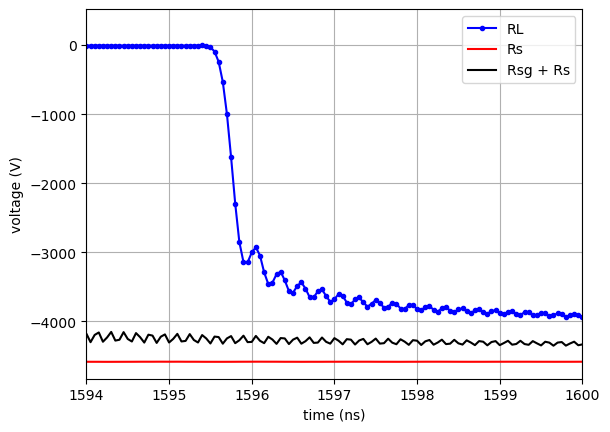

PyObject <matplotlib.legend.Legend object at 0x7fd78a2c0340>

In [21]:
ts = 1e9Δt * collect(1:nt)

xlabel("time (ns)")
grid()
plot(ts,  vRL, "b.-")
plot(ts,  vRs, "r-")
plot(ts, vRsg + vRs, "k-")
xlim([1594, 1600])
ylabel("voltage (V)")
legend(["RL", "Rs", "Rsg + Rs"])

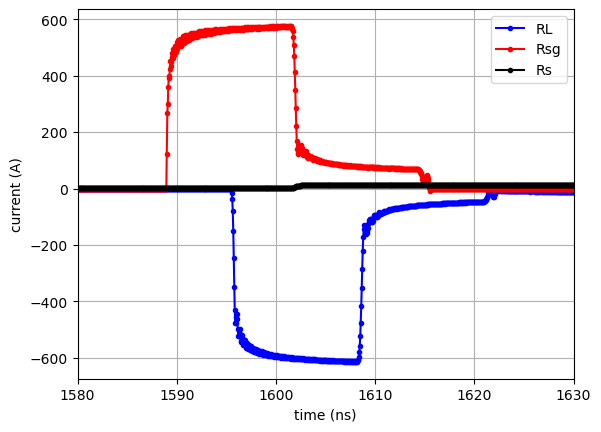

PyObject <matplotlib.legend.Legend object at 0x7fd7ba9d3790>

In [22]:
ts = 1e9Δt * collect(1:nt)

xlabel("time (ns)")
grid()
plot(ts, iRL, "b.-")
plot(ts, iRsg, "r.-")
plot(ts, iRs, "k.-")
xlim([1580, 1630])
ylabel("current (A)")
legend(["RL", "Rsg", "Rs"])

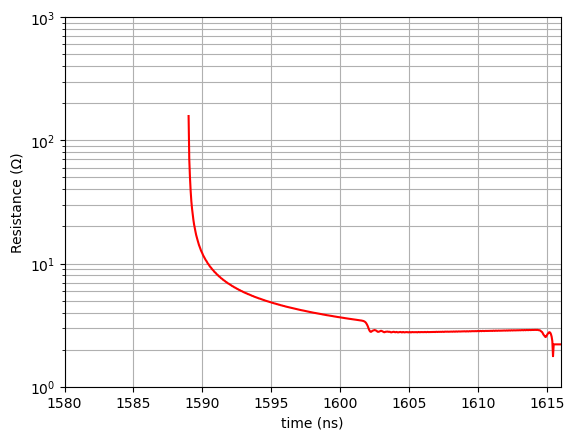

In [23]:
ts = 1e9Δt * collect(1:nt)

semilogy(ts, resistance, "r-")
xlim([1580, 1616])
ylim([1e-0, 1e3])
xlabel("time (ns)")
ylabel("Resistance (Ω)")
grid(which="both")

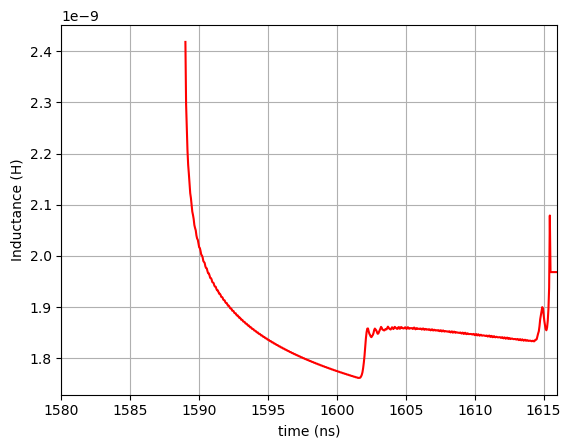

In [24]:
ts = 1e9Δt * collect(1:nt)

plot(ts, inductance, "r-")
xlim([1580, 1616])
xlabel("time (ns)")
ylabel("Inductance (H)")
grid()